In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings; warnings.simplefilter('ignore')

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [5]:
DATASET_ID = 'BIRD_DB_Toxostoma_redivivum_segmented'

In [6]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [7]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'thrasher.pickle'
df_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/syllable_dfs/BIRD_DB_Toxostoma_redivivum_segmented/thrasher.pickle')

In [8]:
syllable_df = pd.read_pickle(df_loc)

In [9]:
syllable_df[:3]

,start_time,end_time,indv,indvi,label,key,rate,spectrogram
0,24.452796,24.545296,CATH-CP1,0,nhv,2009-03-21_08-44-00-000000_1669,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,388.917194,389.066694,CATH-TLR8,0,avb,2012-03-29_07-55-00-000000_13484,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,50.144617,50.266617,CATH-TLR12,0,anj,2012-03-27_08-12-00-000000_11234,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [34]:
labels_sorted = pd.DataFrame(
    {i: [sum(syllable_df.label == i)]
     for i in syllable_df.label.unique()}).T.sort_values(
         by=0, ascending=False)[:100].T
labels_sorted

,nct,aut,nfo,aiz,alc,acb,arp,aqh,ngs,ncr,...,aqa,adh,aft,akr,afu,ahr,azw,bfi,ago,acr
0,227,218,198,189,163,163,161,160,159,158,...,62,59,58,58,58,57,57,57,57,56


In [13]:
len(syllable_df)

20568

Text(0.5, 1.0, 'min')

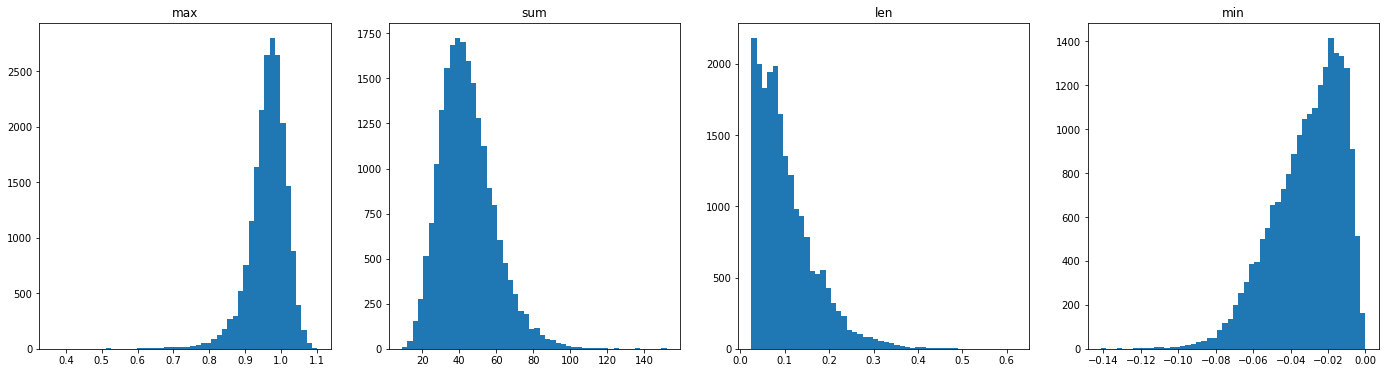

In [14]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

In [15]:
len(syllable_df)

20568

In [16]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [17]:
specs = list(syllable_df.spectrogram.values)
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(20568, 704)

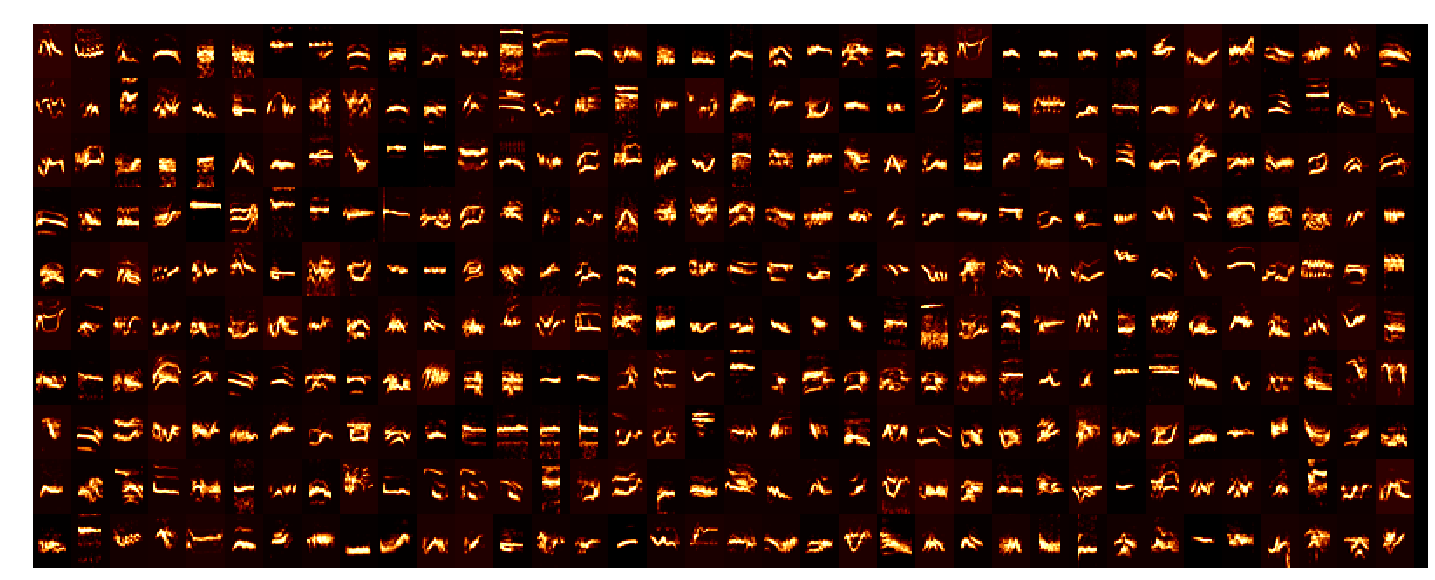

In [18]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

### cluster

In [20]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [28]:
cuml_umap = cumlUMAP()#min_dist=0.25)
embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [29]:
#fit = umap.UMAP(min_dist=0.25)

In [30]:
np.shape(specs_flattened)

(20568, 704)

In [31]:
z  = list(embedding)
z = np.vstack(z)

(-5, 5)

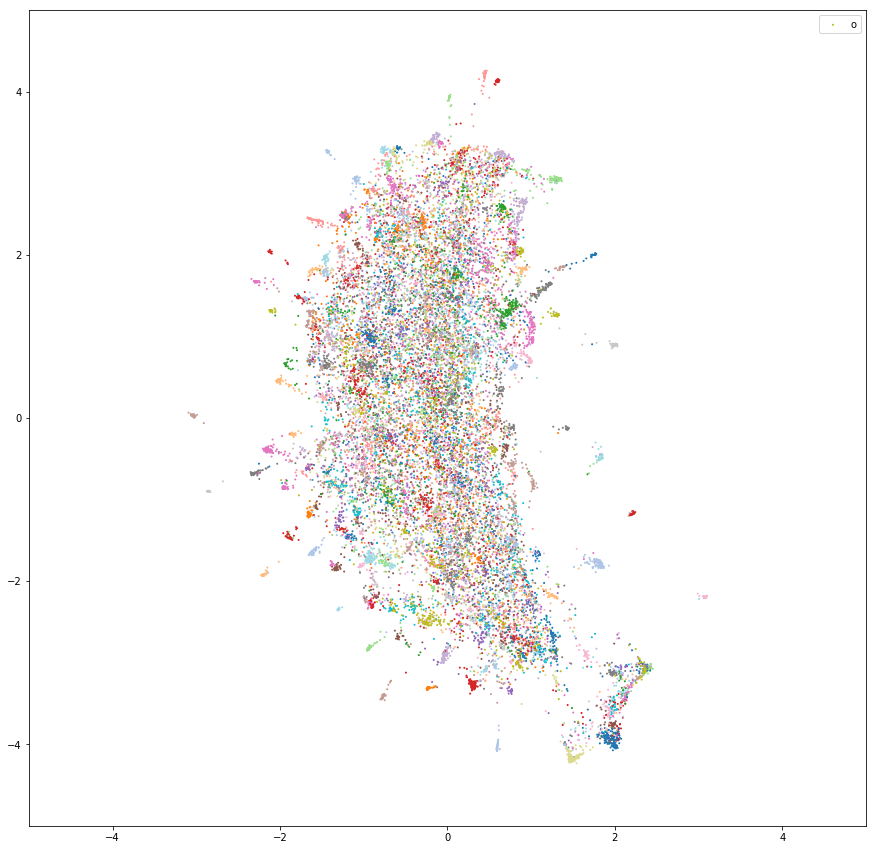

In [32]:
fig, ax = plt.subplots(figsize=(15, 15))
#scatter_projections(projection=z, alpha=0.05, labels=None, s=5, ax=ax)
scatter_projections(
    projection=z,
    alpha=1,
    labels=syllable_df.label.values,
    s=1,
    ax=ax,
)
ax.legend('off')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

(-5, 5)

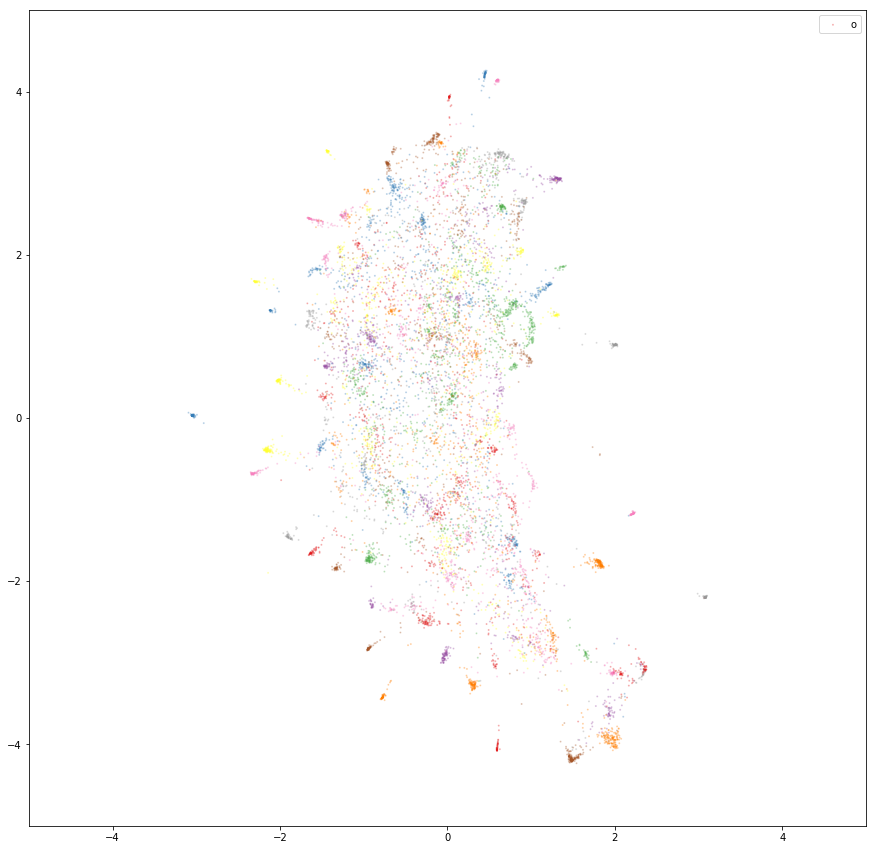

In [36]:
mask = syllable_df.label.isin(list(labels_sorted.columns))
fig, ax = plt.subplots(figsize=(15, 15))
scatter_projections(
    projection=z[mask],
    alpha=0.25,
    labels=syllable_df[mask].label.values,
    color_palette = 'Set1',
    s=1,
    ax=ax,
)
ax.legend('off')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

### unique-individuals

In [37]:
indvs_sorted = pd.DataFrame(
    {i: [sum(syllable_df.indv == i)]
     for i in syllable_df.indv.unique()}).T.sort_values(
         by=0, ascending=False)[:10].T
indvs_sorted

,CATH-CP1,CATH-TLR8,CATH-TLR1,CATH-TLR9,CATH-TLR7,CATH-TLR2,CATH-TLR10,CATH-TLR4,CATH-TLR3,CATH-TLR12
0,3644,2748,2151,2014,1634,1541,1017,1001,942,883


In [39]:
syllable_df[:3]

,start_time,end_time,indv,indvi,label,key,rate,spectrogram
0,24.452796,24.545296,CATH-CP1,0,nhv,2009-03-21_08-44-00-000000_1669,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,388.917194,389.066694,CATH-TLR8,0,avb,2012-03-29_07-55-00-000000_13484,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,50.144617,50.266617,CATH-TLR12,0,anj,2012-03-27_08-12-00-000000_11234,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [41]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 


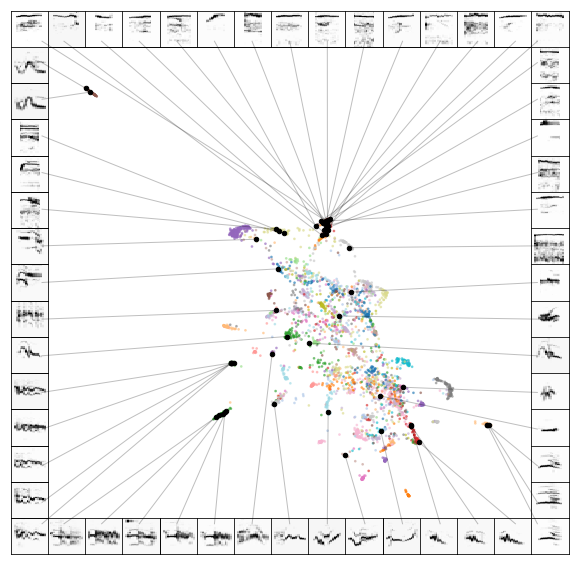

CATH-CP1


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 


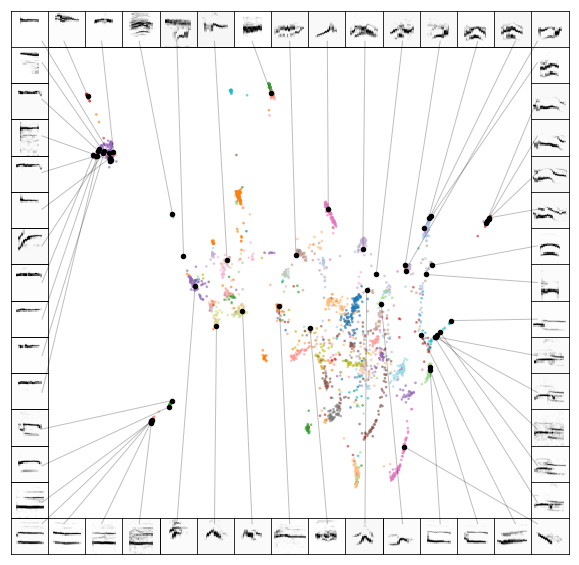

CATH-TLR8


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 


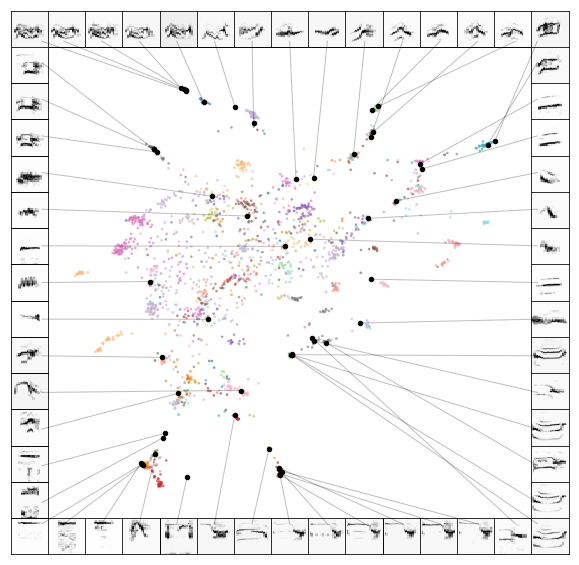

CATH-TLR1


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 


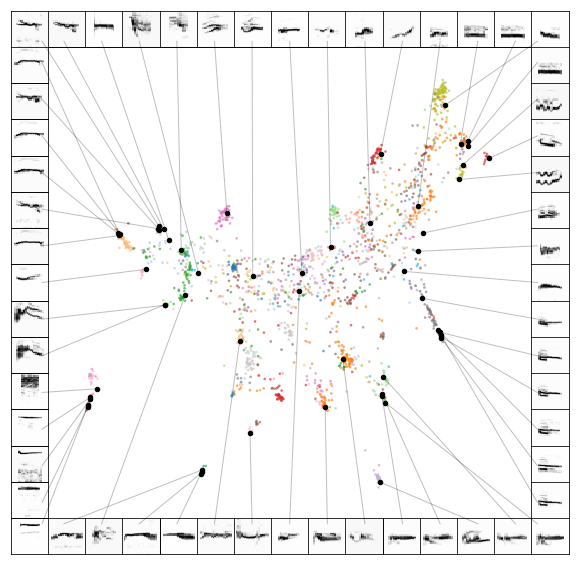

CATH-TLR9


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 


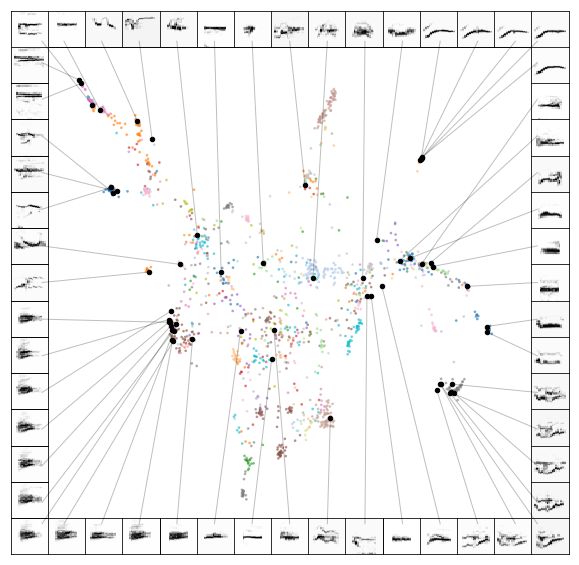

CATH-TLR7


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 


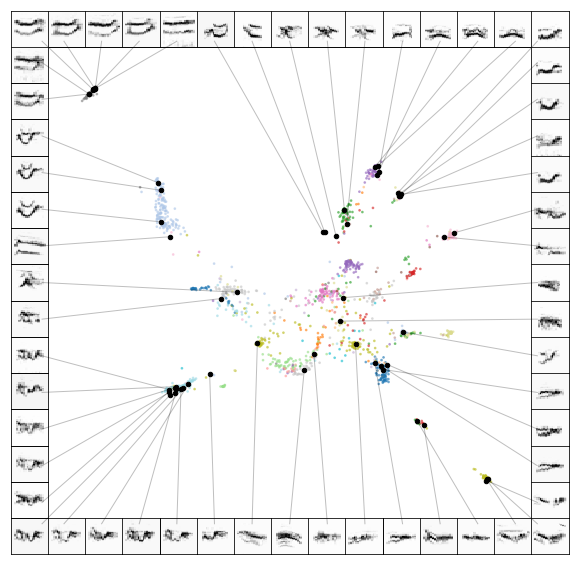

CATH-TLR2


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 


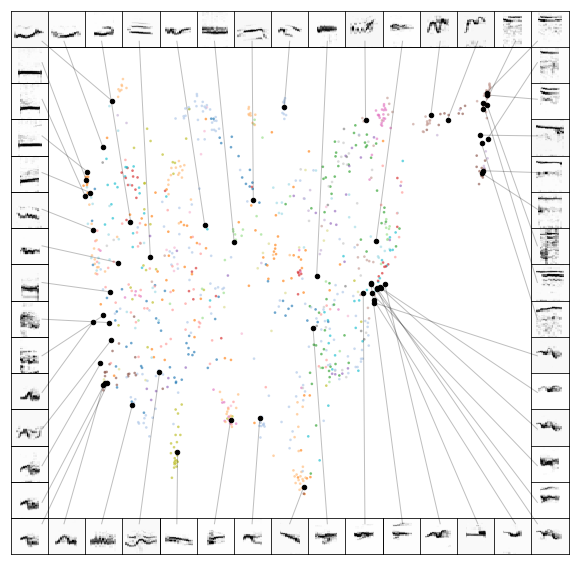

CATH-TLR10


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 


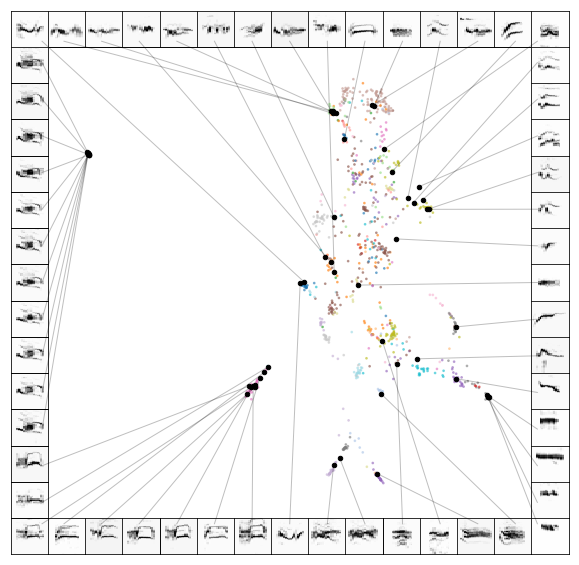

CATH-TLR4


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 


KeyboardInterrupt: 

In [42]:
min_elements_in_cluster = 1#25
for indv in tqdm(list(indvs_sorted.columns)):
    indv_df = syllable_df[syllable_df.indv == indv]
    labels_sorted = pd.DataFrame(
        {i: [sum(indv_df.label == i)]
         for i in indv_df.label.unique()}).T.sort_values(
             by=0, ascending=False).T
    labels_of_interest = list(labels_sorted.T[labels_sorted.T.values>min_elements_in_cluster].index)
    indv_df = indv_df[indv_df.label.isin(labels_of_interest)]
    
    specs = list(indv_df.spectrogram.values)
    specs = [norm(i) for i in specs]
    specs_flattened = flatten_spectrograms(specs)
    np.shape(specs_flattened)
    mask = indv_df.label.isin(list(labels_sorted.columns))
    specs_flattened = specs_flattened[mask]
    cuml_umap = cumlUMAP()
    embedding_mask = cuml_umap.fit_transform(specs_flattened)
    
    scatter_spec(
        embedding_mask,
        np.array(specs),
        column_size=15,
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': indv_df.label.values,
            'alpha': .5,
            's': 3,
            'show_legend': False,
            'color_palette': 'tab20'
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );
    #save_fig(FIGURE_DIR / 'CATH' / ('CATH_'+ indv), dpi=300, save_jpg=True)
    plt.show()
    print(indv)
